# Libraries:

In [2]:
import mysql.connector as sql
import pandas as pd
import os
import matplotlib.pyplot as plt
import pandas as pad 
import statistics
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from scipy.stats import f_oneway

# Exploring the database:

In [4]:
df = pd.read_csv('clinical_data.csv', header=0, delimiter=';', decimal=',')

print("Column names:", df.columns)

number_of_men = df[df['gender'] == 'M'].shape[0]
print("Number of men:", number_of_men)
number_of_women = df[df['gender'] == 'F'].shape[0]
print("Number of women:", number_of_women)

print(df.iloc[:, 1:].head())

Column names: Index(['id', 'surgery', 'OMS', 'survival', 'IDH', 'ATRK', 'gender'], dtype='object')
Number of men: 101
Number of women: 75
      surgery  OMS  survival  IDH ATRK gender
0  incomplete    0       213  NaN  NaN      F
1      biopsy    2       307  NaN  NaN      M
2      biopsy    2       207  NaN  NaN      F
3  incomplete    1       493  NaN  NaN      F
4  incomplete    1       768  NaN  NaN      M


## Data cleaning

In [8]:
df['surgery'] = df['surgery'].replace({'incomplete': 'incomplete surgery', 'complete': 'complete surgery'})
# mettre le drop de na pour la surgery

## Definition of analysis functions

In [11]:
def ExplorationDataPreliminaries_diagram(df, colonne): 

    custom_palette = ["#00244A", "#006A89", "#37B4AA"]
    df_women = df[df['gender'] == 'F']
    df_men = df[df['gender'] == 'M']  
    
    data = (df[colonne].value_counts() * 100) / len(df)
    data_women = (df_women[colonne].value_counts() * 100) / len(df_women)
    data_men = (df_men[colonne].value_counts() * 100) / len(df_men)

    fig, axs = plt.subplots(1, 3, figsize=(20, 10)) 

    axs[0].pie(x=data, labels=data.index, colors=custom_palette[:len(data)], autopct='%1.2f%%', textprops={'color': 'black'})
    axs[0].set_title(f"Overall distribution ({colonne})", color='black')

    axs[1].pie(x=data_women, labels=data_women.index, colors=custom_palette[:len(data_women)], autopct='%1.2f%%', textprops={'color': 'black'})
    axs[1].set_title(f"Women’s distribution ({colonne})", color='black')

    axs[2].pie(x=data_men, labels=data_men.index, colors=custom_palette[:len(data_men)], autopct='%1.2f%%', textprops={'color': 'black'})
    axs[2].set_title(f"Men’s distribution ({colonne})", color='black')

    for ax in axs:
        for txt in ax.texts:
            if '%' in txt.get_text():
                txt.set_color('white')
    
    plt.tight_layout()
    plt.show()

    fig.savefig(f'{colonne}_diagramme.png')


In [13]:
def ExplorationDataPreliminaries_histplot_boxplot(df, colonne):

    custom_palette = ["#00244A", "#006A89", "#37B4AA"]
    
    df_women = df[df['gender'] == 'F']
    df_men = df[df['gender'] == 'M']

    print(f"Minimum value of {colonne} :", round(df[colonne].min(), 2))
    print(f"Maximum value of {colonne} :", round(df[colonne].max(), 2))
    print(f"Average value of {colonne} :", round(df[colonne].mean(), 2))
    print(f"Standard deviation value of {colonne} :", round(df[colonne].std(), 2))
        
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))  

    sns.histplot(data=df, x=colonne, kde=False, ax=axs[0, 0], color=custom_palette[0]) 
    axs[0, 0].set_title(f'Global ({colonne})')
    sns.histplot(data=df_women, x=colonne, kde=False, ax=axs[0, 1], color=custom_palette[1]) 
    axs[0, 1].set_title(f'Women ({colonne})')
    sns.histplot(data=df_men, x=colonne, kde=False, ax=axs[0, 2], color=custom_palette[2]) 
    axs[0, 2].set_title(f'Men ({colonne})')

    sns.boxplot(data=df, x=colonne, ax=axs[1, 0], color=custom_palette[0])
    sns.stripplot(data=df, x=colonne, dodge=True, ax=axs[1, 0], color="black", jitter=True)
    axs[1, 0].set_title(f'Global ({colonne})')
    sns.boxplot(data=df_women, x=colonne, ax=axs[1, 1], color=custom_palette[1])
    sns.stripplot(data=df_women, x=colonne, dodge=True, ax=axs[1, 1], color="black", jitter=True)
    axs[1, 1].set_title(f'Women ({colonne})')
    sns.boxplot(data=df_men, x=colonne, ax=axs[1, 2], color=custom_palette[2])
    sns.stripplot(data=df_men, x=colonne, dodge=True, ax=axs[1, 2], color="black", jitter=True)
    axs[1, 2].set_title(f'Men ({colonne})')
        
    plt.tight_layout()
    plt.show()  
    
    fig.savefig(f'{colonne}_histo_boxplot.png')


In [15]:
def perform_anova_analysis(df, variable):

    surgery_groups = [
        df[df['surgery'] == 'biopsy'][variable],
        df[df['surgery'] == 'incomplete surgery'][variable],
        df[df['surgery'] == 'complete surgery'][variable]
    ]

    f_statistic, p_value = f_oneway(*surgery_groups)

    print(f"ANOVA - Comparison of {variable} by surgery type:")
    print(f"F-statistic: {f_statistic}")
    print(f"p-value: {p_value}")
    
    print("\nDescriptive statistics:")
    for surgery_type in ['biopsy', 'incomplete surgery', 'complete surgery']:
        group = df[df['surgery'] == surgery_type][variable]
        print(f"\n{surgery_type.capitalize()}:")
        print(f"Number of patients: {len(group)}")
        print(f"Mean {variable}: {group.mean():.2f}")
        print(f"Standard deviation {variable}: {group.std():.2f}")

    if variable == 'survival':
        plt.figure(figsize=(10, 6))

        
        order = ['biopsy', 'incomplete surgery', 'complete surgery']
        
        unique_surgeries = df['surgery'].unique()
        print(f"Catégories trouvées dans 'surgery': {unique_surgeries}")
        
        if not set(['biopsy', 'incomplete surgery', 'complete surgery']).issubset(unique_surgeries):
            raise ValueError("Les catégories attendues pour 'surgery' sont manquantes.")
   
        summary_df = (
            df.groupby('surgery')[variable]
            .agg(['mean', 'std'])
            .reindex(order)
            .reset_index()
        )

        colors = ['#00244A', '#006A89', '#37B4AA']

        sns.barplot(x='surgery', y='mean', data=summary_df, errorbar=None, order=order, palette=colors)

        for i, (mean, std) in enumerate(zip(summary_df['mean'], summary_df['std'])):
            lower_error = mean - std
            upper_error = mean + std

            if lower_error < 0:
                lower_error = 0  
            if upper_error > mean:
                plt.plot([i, i], [mean, upper_error], color='black', linewidth=1)
                plt.plot([i - 0.1, i + 0.1], [upper_error, upper_error], color='black', linewidth=1)
            
            if summary_df['surgery'].iloc[i] in ['incomplete surgery', 'complete surgery']:
                plt.text(i, upper_error - 10, '*', color='black', fontsize=20, ha='center')
        
        plt.figtext(0.5, -0.1, "Impact of surgery quality on overall survival: Mean ± SD, n=70 ; 62 ; 44 for biopsy, surgery incomplete, surgery complete respectively, * p < 0.05 vs biopsy'.", ha="center", va="top", fontsize=9)
        plt.subplots_adjust(bottom=-0.02, top=0.8)
        plt.xlabel('')
        plt.ylabel(f'{variable} (days)')
        plt.savefig('survival_distribution_by_surgery_type.png', bbox_inches='tight', dpi=150)
        plt.show()


# Resultats

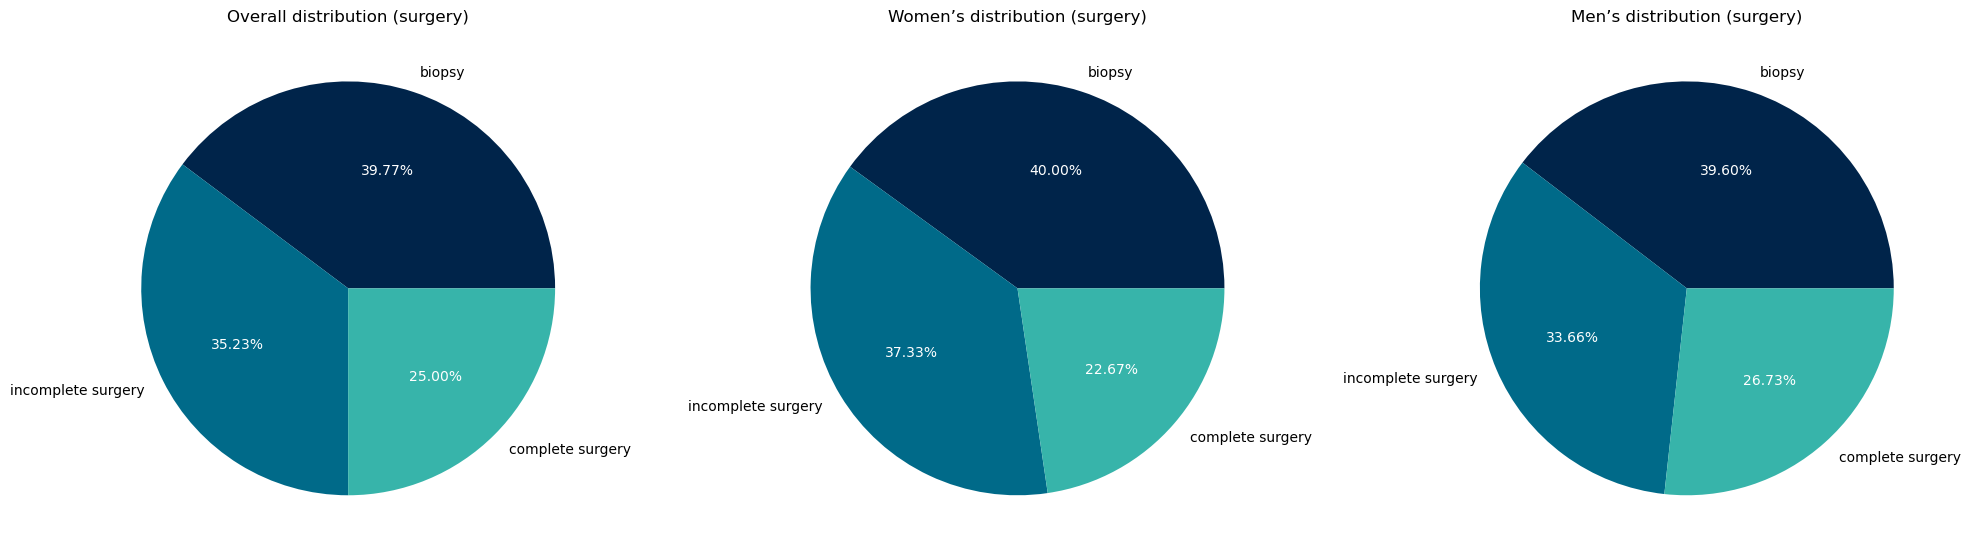

In [18]:
ExplorationDataPreliminaries_diagram(df, 'surgery')

Minimum value of survival : 23
Maximum value of survival : 1600
Average value of survival : 355.25
Standard deviation value of survival : 261.59


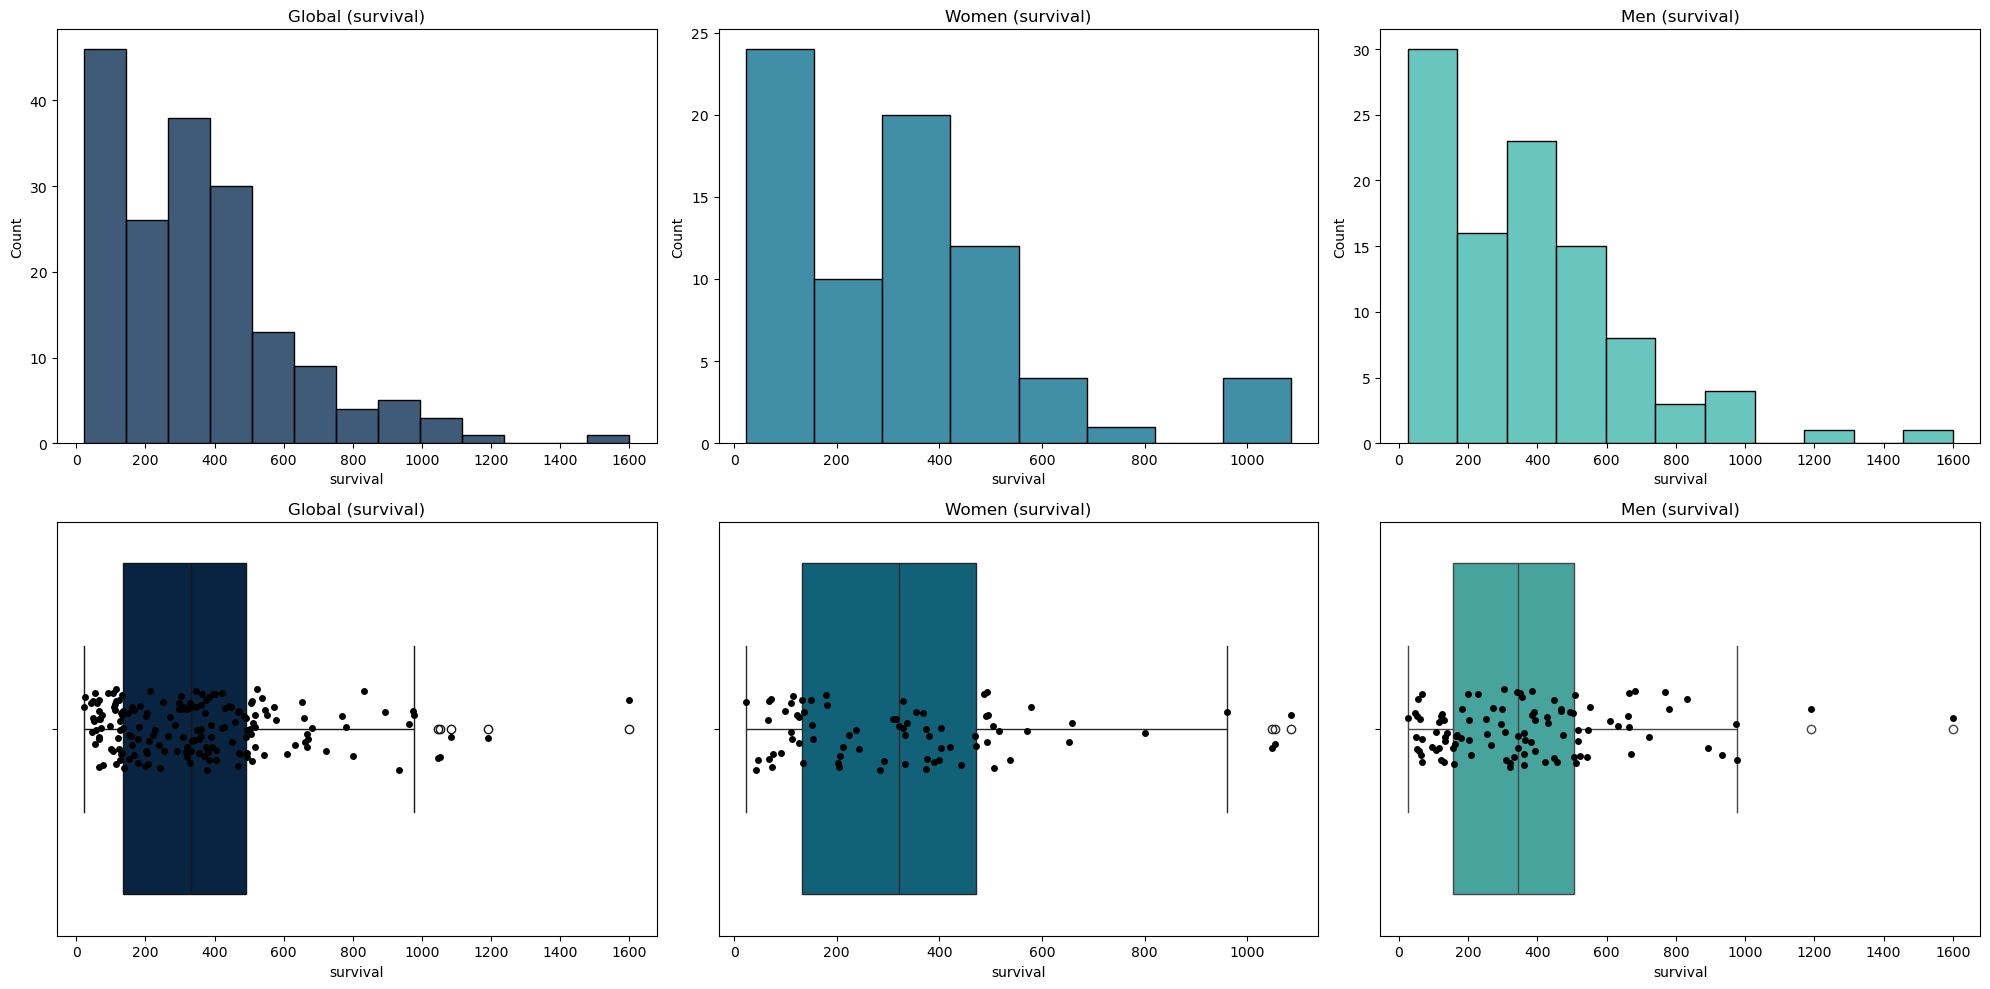

In [20]:
ExplorationDataPreliminaries_histplot_boxplot(df, 'survival')

ANOVA - Comparison of survival by surgery type:
F-statistic: 16.272202652103257
p-value: 3.346942943129593e-07

Descriptive statistics:

Biopsy:
Number of patients: 70
Mean survival: 238.49
Standard deviation survival: 191.64

Incomplete surgery:
Number of patients: 62
Mean survival: 386.69
Standard deviation survival: 259.43

Complete surgery:
Number of patients: 44
Mean survival: 496.70
Standard deviation survival: 282.83
Catégories trouvées dans 'surgery': ['incomplete surgery' 'biopsy' 'complete surgery']


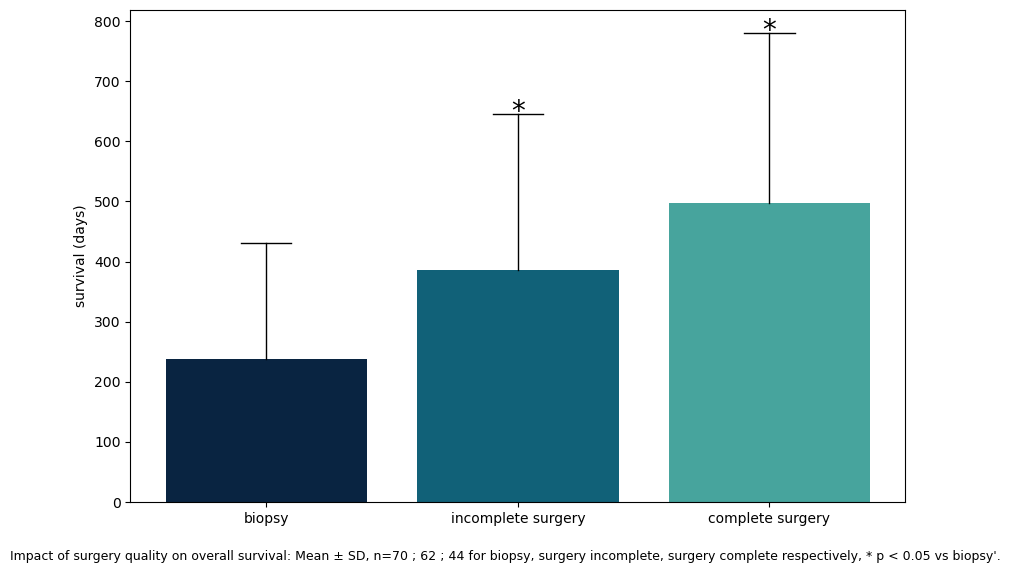

In [22]:
perform_anova_analysis(df, 'survival')